# Surface Event Analysis
###### This notebook analyzes surface event waveforms and calculates location, directivity, and velocity
###### Francesca Skene
###### fskene@uw.edu
###### Created: 7/22/22

Import Modules

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import UTCDateTime
import pandas as pd
from obspy.clients.fdsn.client import Client
client2 = Client("IRIS")
from obspy.geodetics import *
import requests
import glob
import h5py
import sys
sys.path.append("/data/wsd01/pnwstore/")
from obspy.signal.cross_correlation import *
from mpl_toolkits import mplot3d
import tsfresh as tf
import scipy

from scipy import optimize
from scipy.optimize import curve_fit
from pnwstore.mseed import WaveformClient
from obspy.core.utcdatetime import UTCDateTime
client = WaveformClient()


Parameters

In [2]:
t_before = 120 #number of seconds before pick time
t_after = 120 #number of seconds after pick time
fs = 40 #sampling rate that all waveforms are resampled to
window = 30 #window length of the signal
pr = 98 #percentile
thr = 7 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface
t_beginning = UTCDateTime(2001,1,1,0,0,0)
t_end = UTCDateTime(2021,12,31,23,59)
low_cut = 2
high_cut = 8
az_thr = 1500 #threshold of distance from center of volcano that a station's azimuth counts towards direction flow

## Define Functions

This functions cross correlates envelopes of waveforms to calculate picktimes

In [3]:
def pick_time(ref_env, data_env_dict):
    est_picktimes = []
    est_picktimes.append(str(tr.stats.starttime + t_before)) 
    xcor = obspy.signal.cross_correlation.correlate(data_env_dict,ref_env,int(5*fs))
    index = np.argmax(xcor)
    cc = round(xcor[index],9) #correlation coefficient
    shift = 5*fs-index #how much it is shifted from the reference envelope
    #print(shift, cc, key)
    
    p = UTCDateTime(est_picktimes[0]) + shift/fs  # p is the new phase pick for each station
    return p

This function resamples the data in the streams to 40 Hz

In [4]:
def resample(st, fs):
    for i in st:
        i.detrend(type='demean')
        i.taper(0.05)
        i.resample(fs)   
    return st

Function to fit data

In [5]:
  def test_func(theta, a,theta0, c):
                    return a * np.cos(theta-theta0)+c

##  Import and organize metadata

### 1. Volcano Data (network and station, labeled with volcano name)

In [6]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('Volcano_Metadata_50km.csv')

Input Volcano Names and Locations

In [7]:
#data obtained from www.lat-long.com
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
volc_lat_lon['Mt_Adams'] = [46.202621, -121.4906384, 3743.2]
volc_lat_lon['Mt_Baker'] = [48.7773426,  -121.8132008, 3287.6]
# change the lat and lon of mt st helens to the middle of the dome instead of the highest point
#NOTE: while changing the lat and lon from the peak to the middle of the dome caused the sin curve to look
#differet, the flow direction stayed more or less the same!
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549] #[46.1912, -122.1944, 2549]
volc_lat_lon['Glacier_Peak'] = [48.1112273, -121.1139922, 3213]
volc_lat_lon['Crater_Lake']=[42.907745, -122.143494, 1883]
volc_lat_lon['Mt_Hood']=[45.373221, -121.696509, 3428.7]
volc_lat_lon['Newberry']=[43.7220653, -121.2344654, 2435]

### 3. Surface Event Data from PNSN

In [8]:
#"su" is the label for surface event

df3= pd.read_csv('../surface_events/PNSN_Pick_Label.csv')

label = df3['Label'].values.tolist()

surface_label = df3[df3['Label']== 'su']['Label'].values.tolist()
net = df3[df3['Label']== 'su']['Network'].values.tolist()
sta = df3[df3['Label']== 'su']['Station'].values.tolist()
evt_id = df3[df3['Label']== 'su']['Event_ID'].values.tolist()
start_time = df3[df3['Label']== 'su']['Picktime'].values.tolist()                               



## Calculating seasonal occurence of events

In [ ]:
# for the plots:
    #maybe get average slope for each volcano?

In [ ]:
for name in volc_lat_lon:
    events = []
    starttimes = []
    stations = []
    networks = []
    for i in range(0, len(start_time)):
            #associates a volcano to each station based on 'Volcano_Metadata50km.csv'
        try:
            associated_volcano = df[df['Station']== sta[i]]['Volcano_Name'].values[0]
        except: 
            associated_volcano = 'unknown'
    
        if associated_volcano == name and evt_id[i]!=evt_id[i-1]:
            events.append(evt_id[i])
            starttimes.append(start_time[i])
            stations.append(sta[i])
            networks.append(net[i])

    num_events = {}
    for year in range (2001, 2021):
        for month in range (1, 13):
            Nevt = []
            period = str(year)+"_"+str(month)
            t0 = UTCDateTime(year, month, 1)
            t1 = t0+3600*24*30
            #t1 = UTCDateTime(year, month+1, 1)
            for i in range(0, len(starttimes)):
                if t0<starttimes[i]<t1:
                    Nevt.append(events[i])
                    

            if len(Nevt) != 0:
                num_events[period]=len(Nevt)
            if len(Nevt) == 0:
                num_events[period] = 0


    periods = list(num_events.keys())
    num_of_events = list(num_events.values())
    fig = plt.figure(figsize = (60, 10))
    for x in range(0,len(periods)):
        if '5'<=periods[x][-1]<='9':
            plt.bar(periods[x], num_of_events[x], color = 'r', width = 0.4)
        else:
            plt.bar(periods[x],num_of_events[x], color ='b', width = 0.4)
    #plt.bar(periods,num_of_events, color ='b', width = 0.4)
    plt.xlabel("year_month")
    plt.xticks(np.arange(0, len(periods)+1, 12)) #make every year
    plt.ylabel("No. of events")
    plt.title("Number of surface events per month at" + str(name))
    plt.rcParams.update({'font.size': 30})
    plt.show()
    break

### Time Series for the XD temporary network


In [ ]:
#read in the event data from just this time period??
#look at events and see how many XD stations picked them up

### Figure out distance to not include azimuth calculation and eliminate these stations for finding directivity
maybe around 1km

## Plotting and gathering waveforms based on pick times from all event picks

0.560039145576 HOA
0.46717854113 LOO
0.472558348473 SEP
0.614231483636 STD
0.483215968268 SUG
0.334086794634 VALT
0.516315223613 EDM
[   7.55166165   30.06758022   97.189824    262.473136    326.07265472
  356.79152567  358.81122786] original
432.121662426 m/s
0.496975137311 HOA
0.326333096287 LOO
0.376321026187 REM
0.582328185195 SEP
0.285967670903 STD
0.404642126123 SUG
0.29218272795 VALT
0.341128537963 SHW
[   7.55166165   30.06758022   96.70111727  258.03560074  262.473136
  326.07265472  356.79152567  358.81122786] original
35.2327041707 m/s
0.39298611336 OBSR
0.353572469217 PANH
0.303422002324 PARA
0.358406285811 PR05
0.280626679797 RUSH
0.326012814592 SIFT
0.412795674323 FMW
0.480932884258 LO2
0.380530130469 LON
0.337690268791 RCM
0.34510903567 RER
0.282421221965 STAR
[  34.65620748   85.60689877  132.52534771  169.34761961  198.30540121
  198.30540121  238.93727837  264.80511476  265.10415533  276.19935884
  291.75179869  321.1974987 ] original
109.81934603 m/s
0.502647189366 H

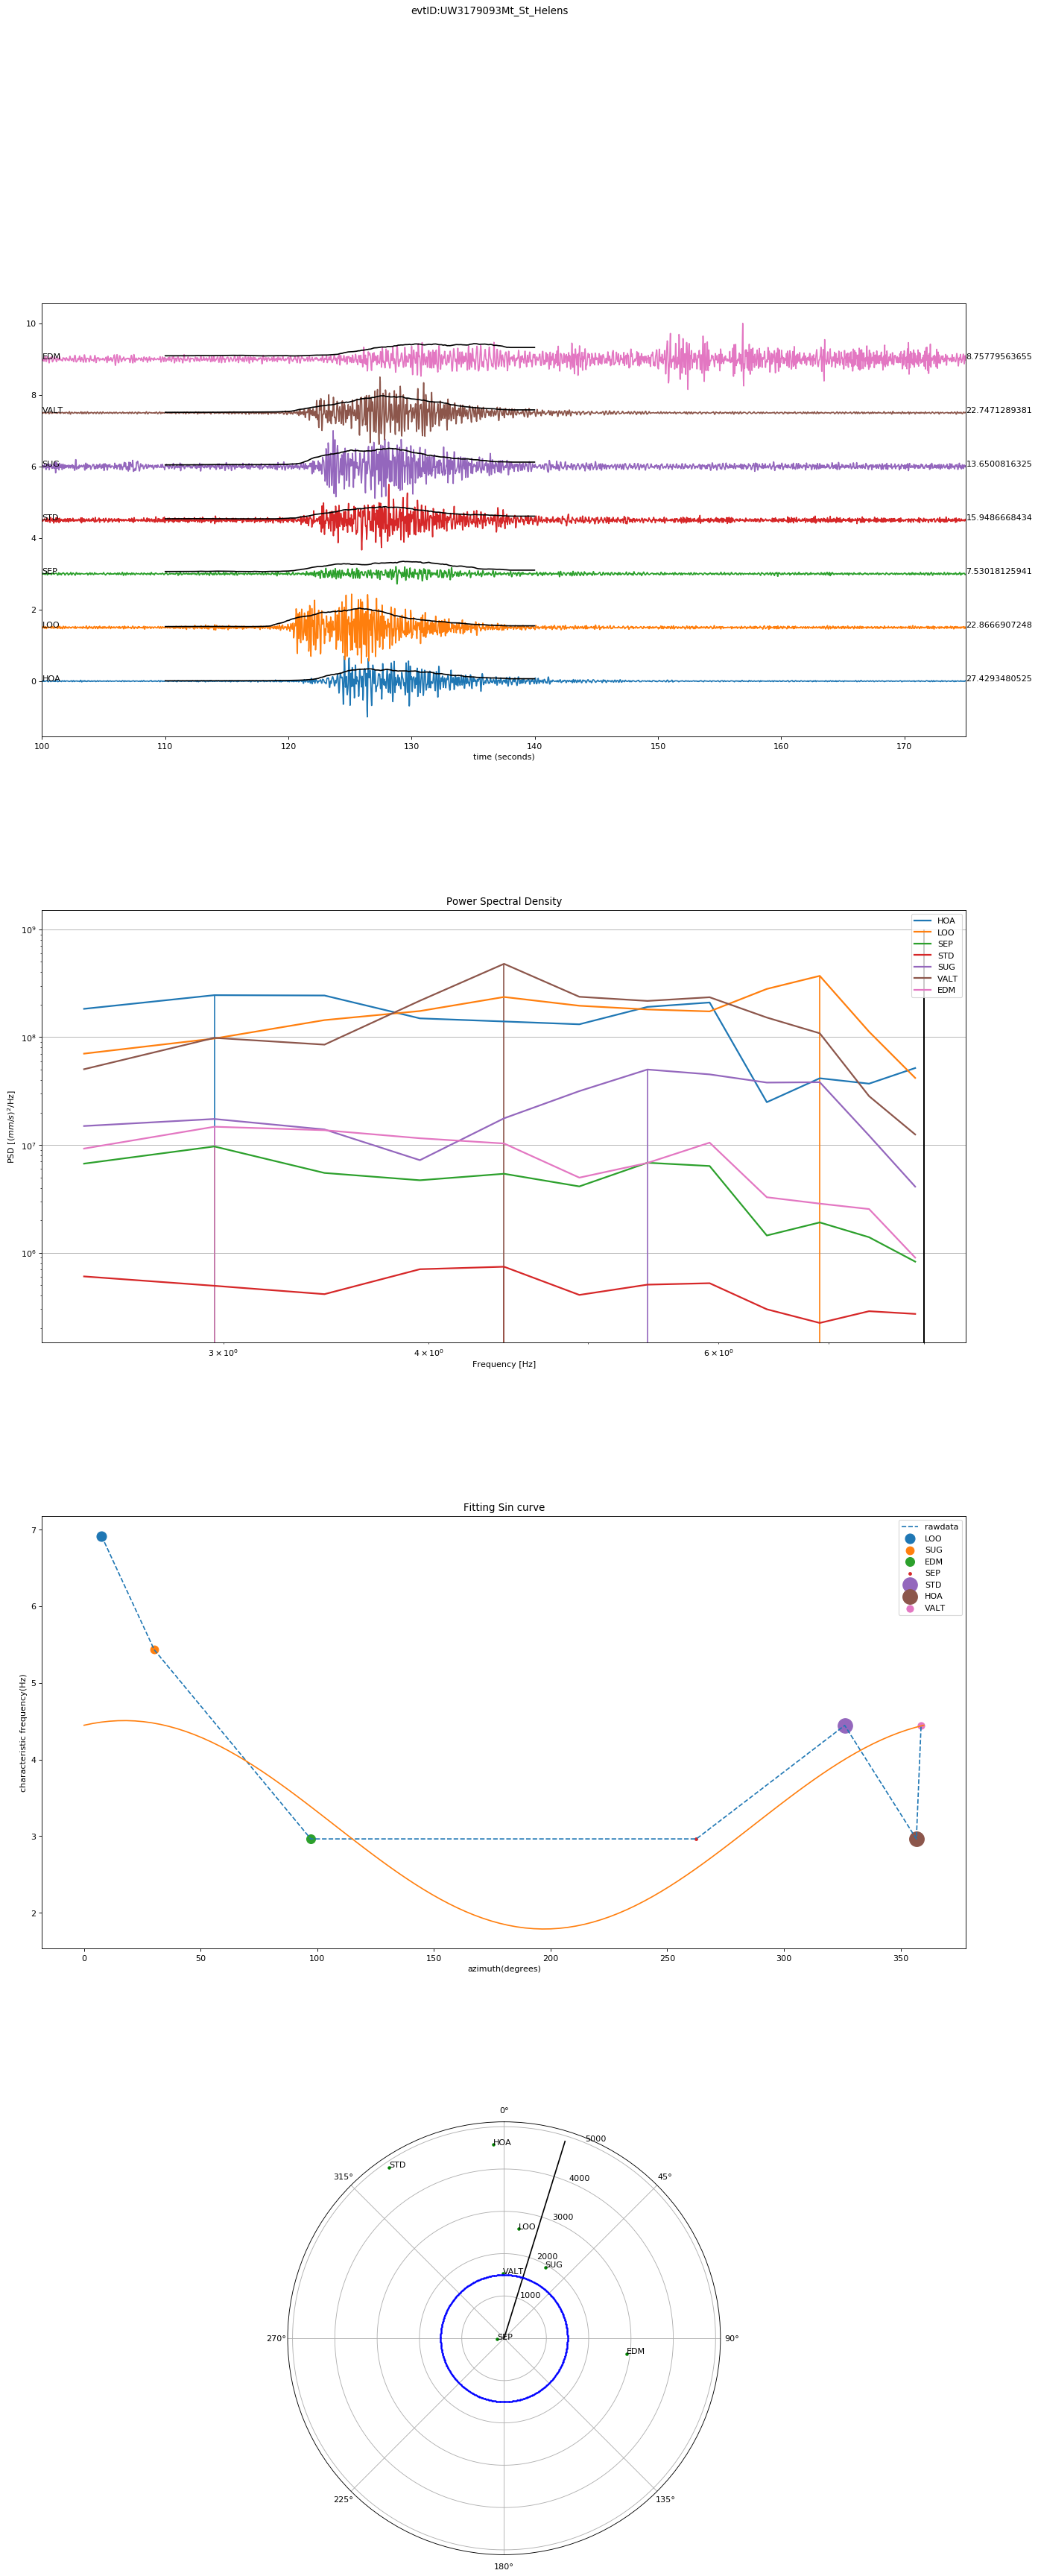

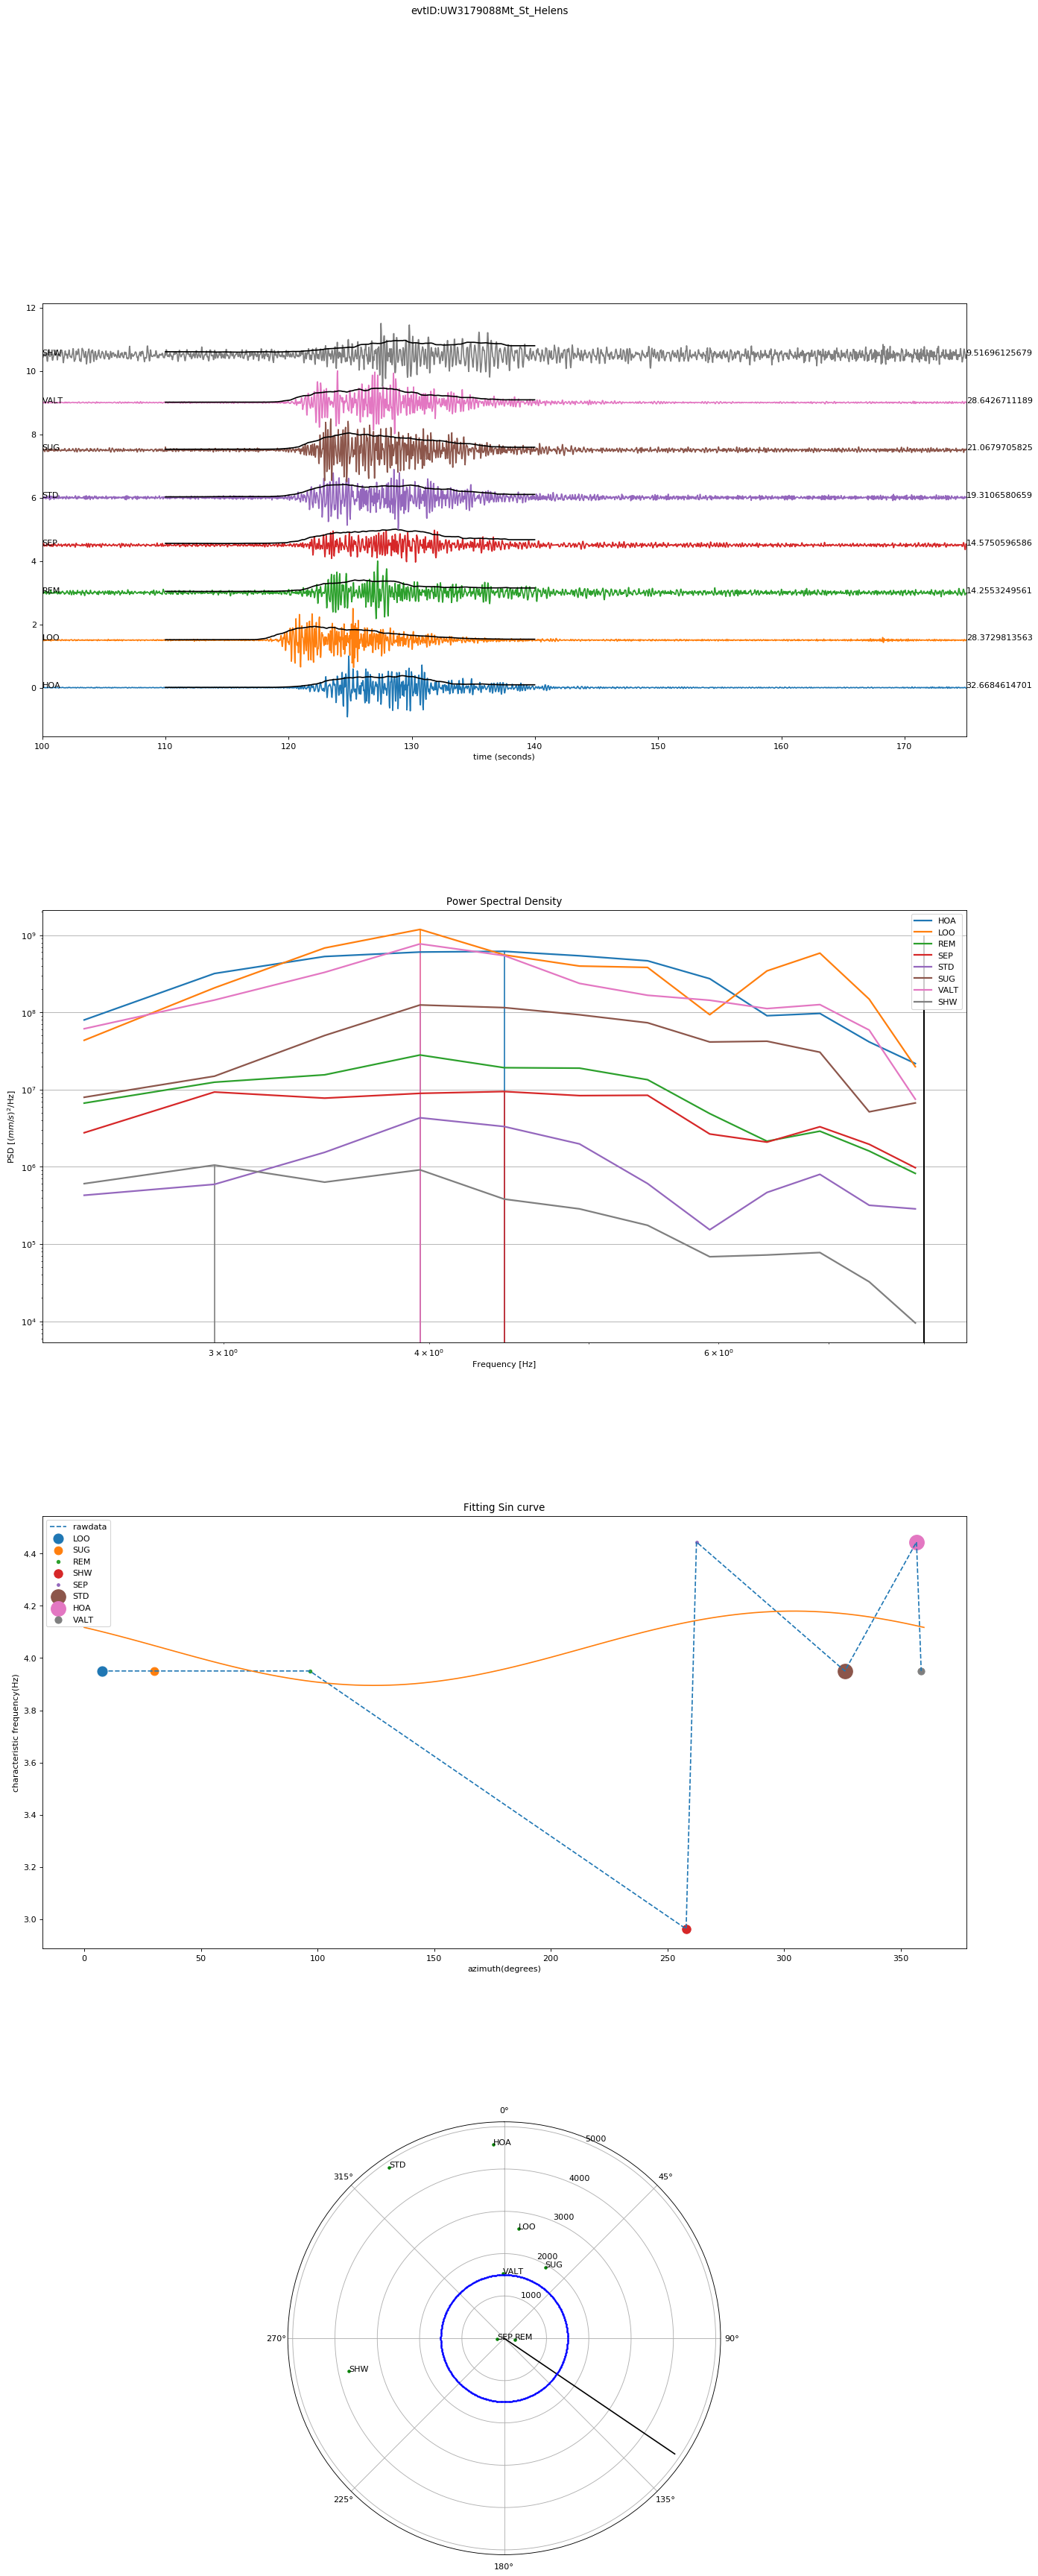

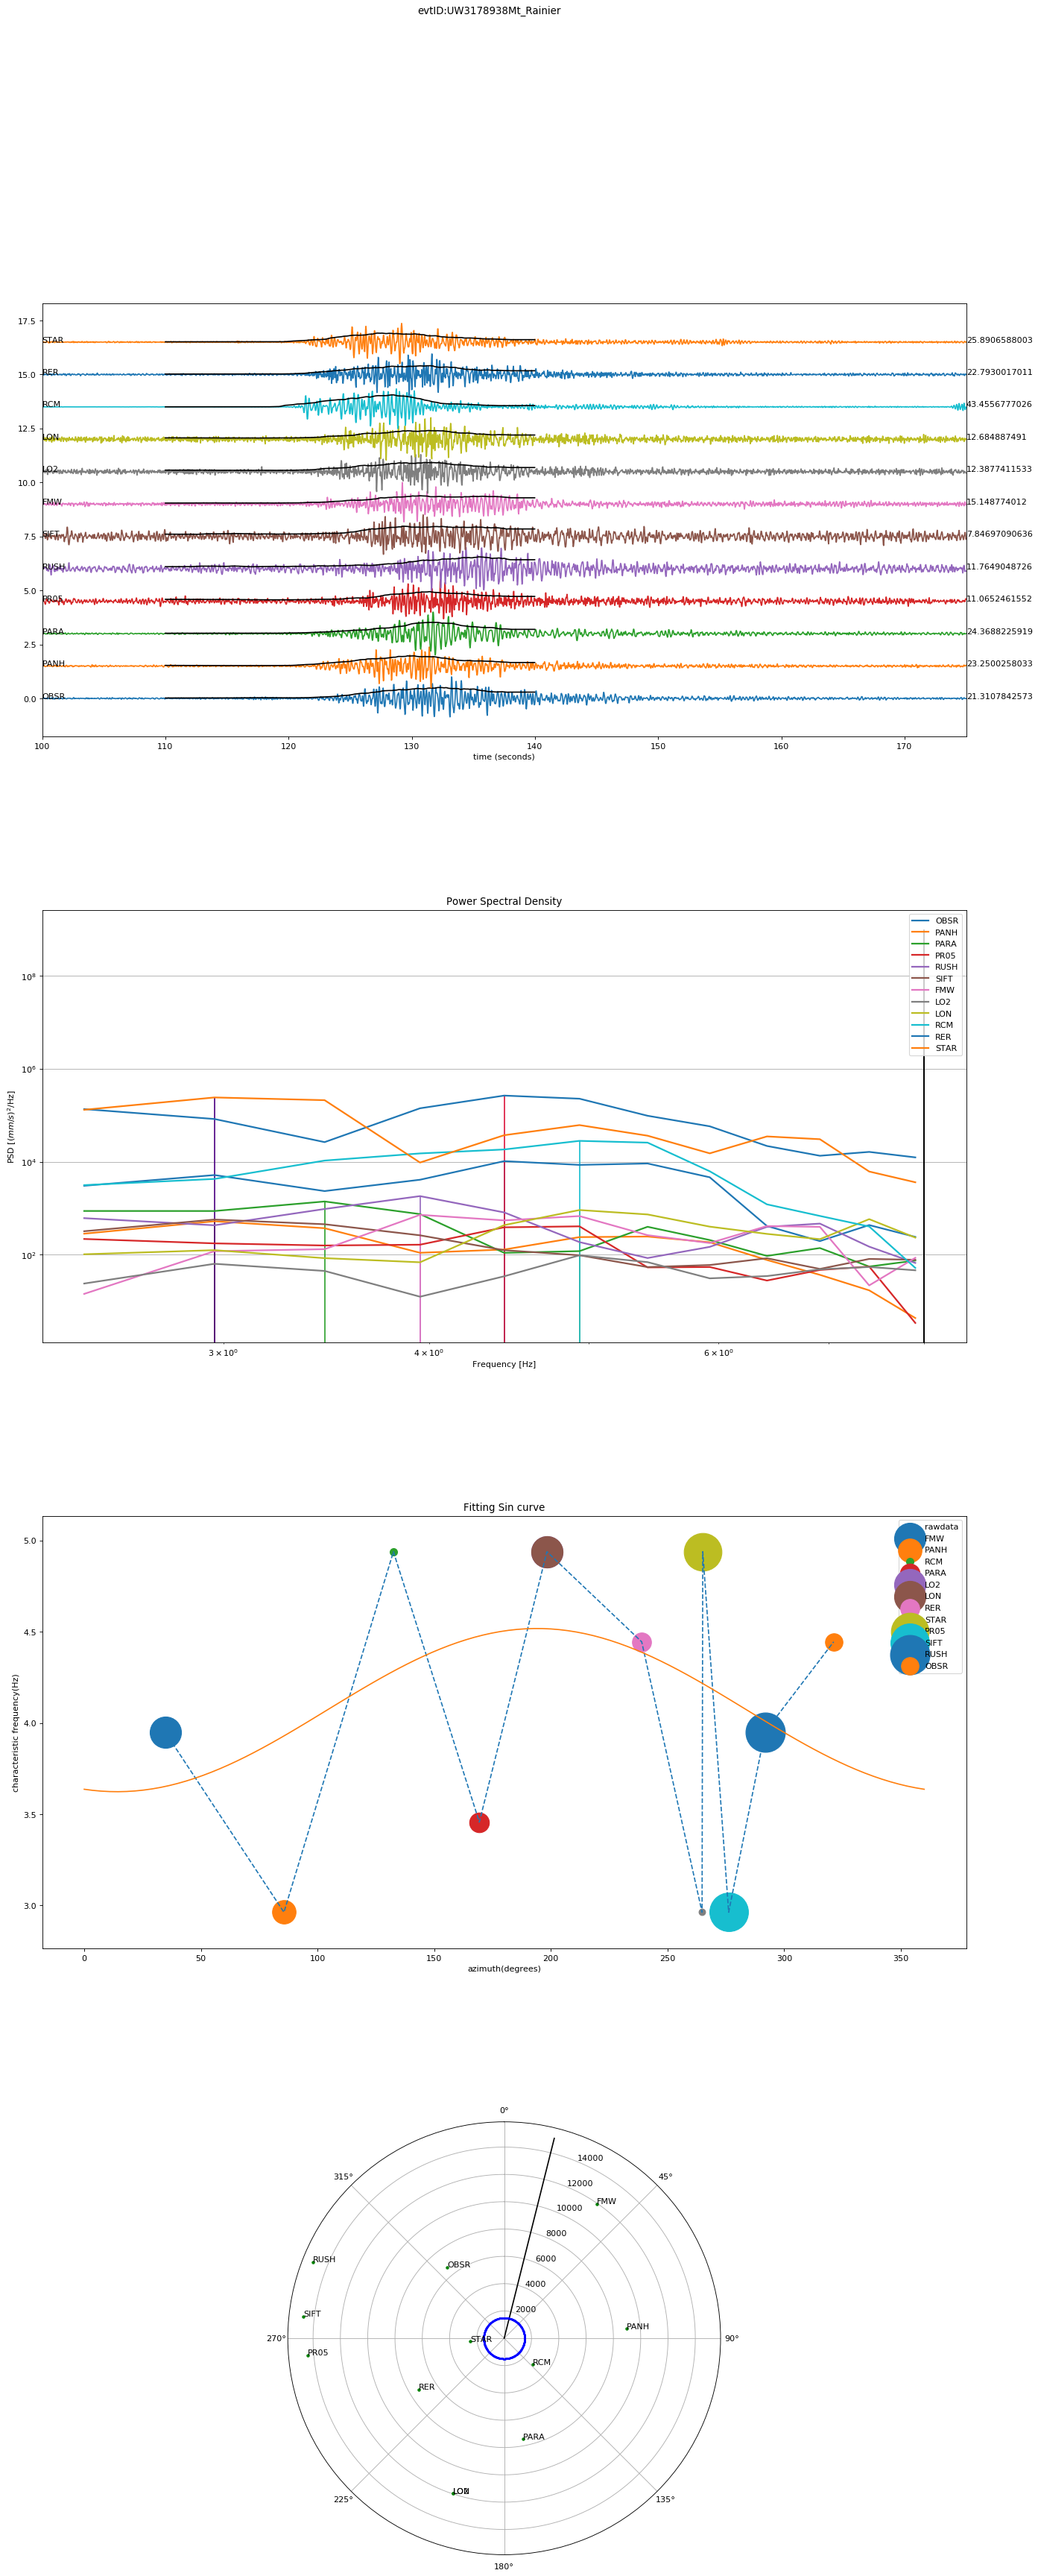

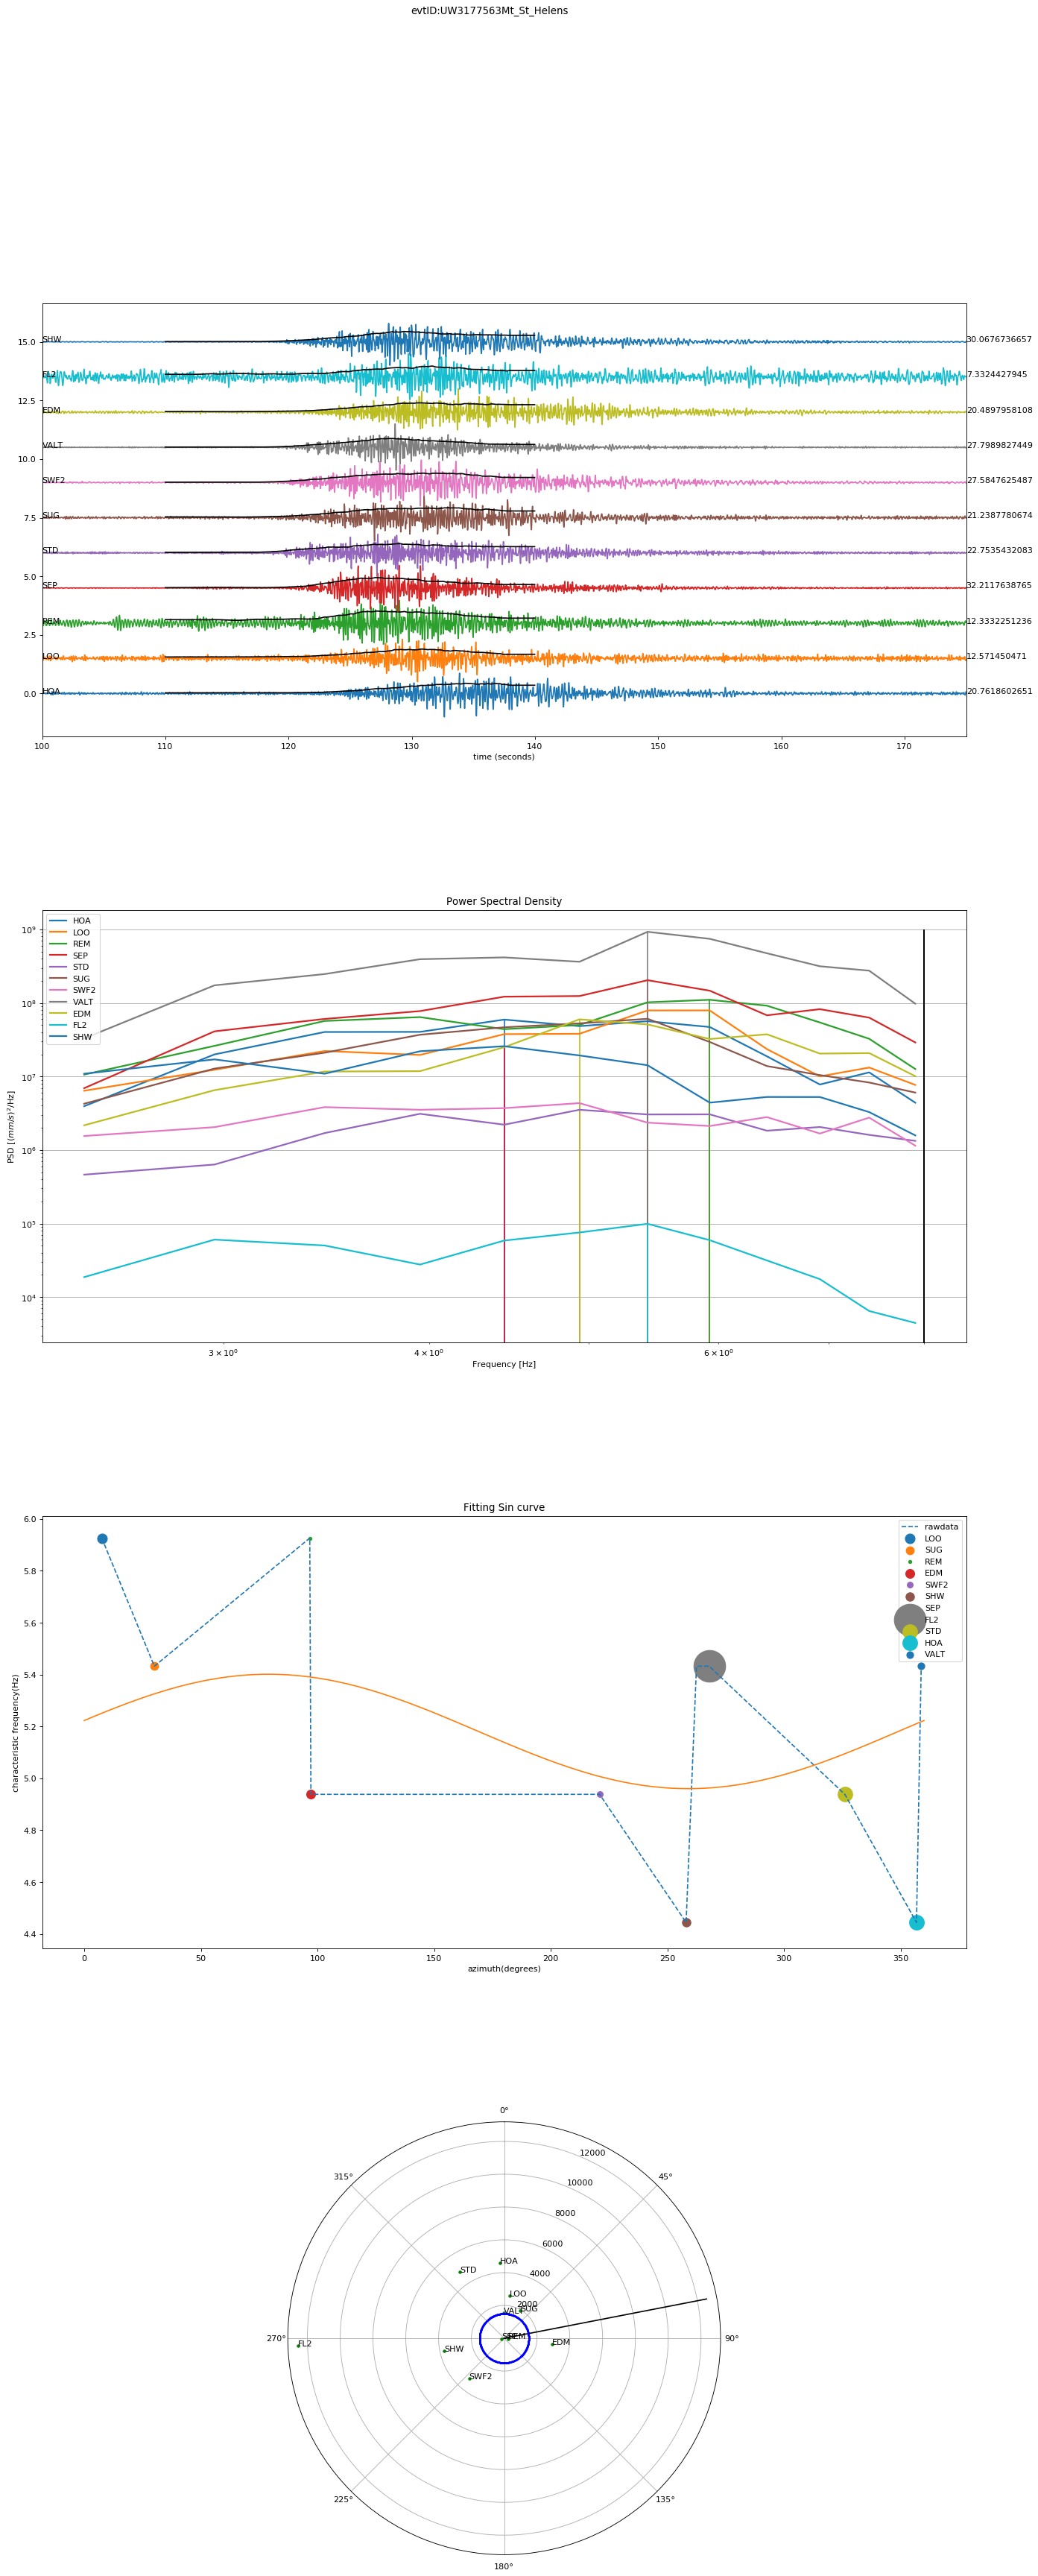

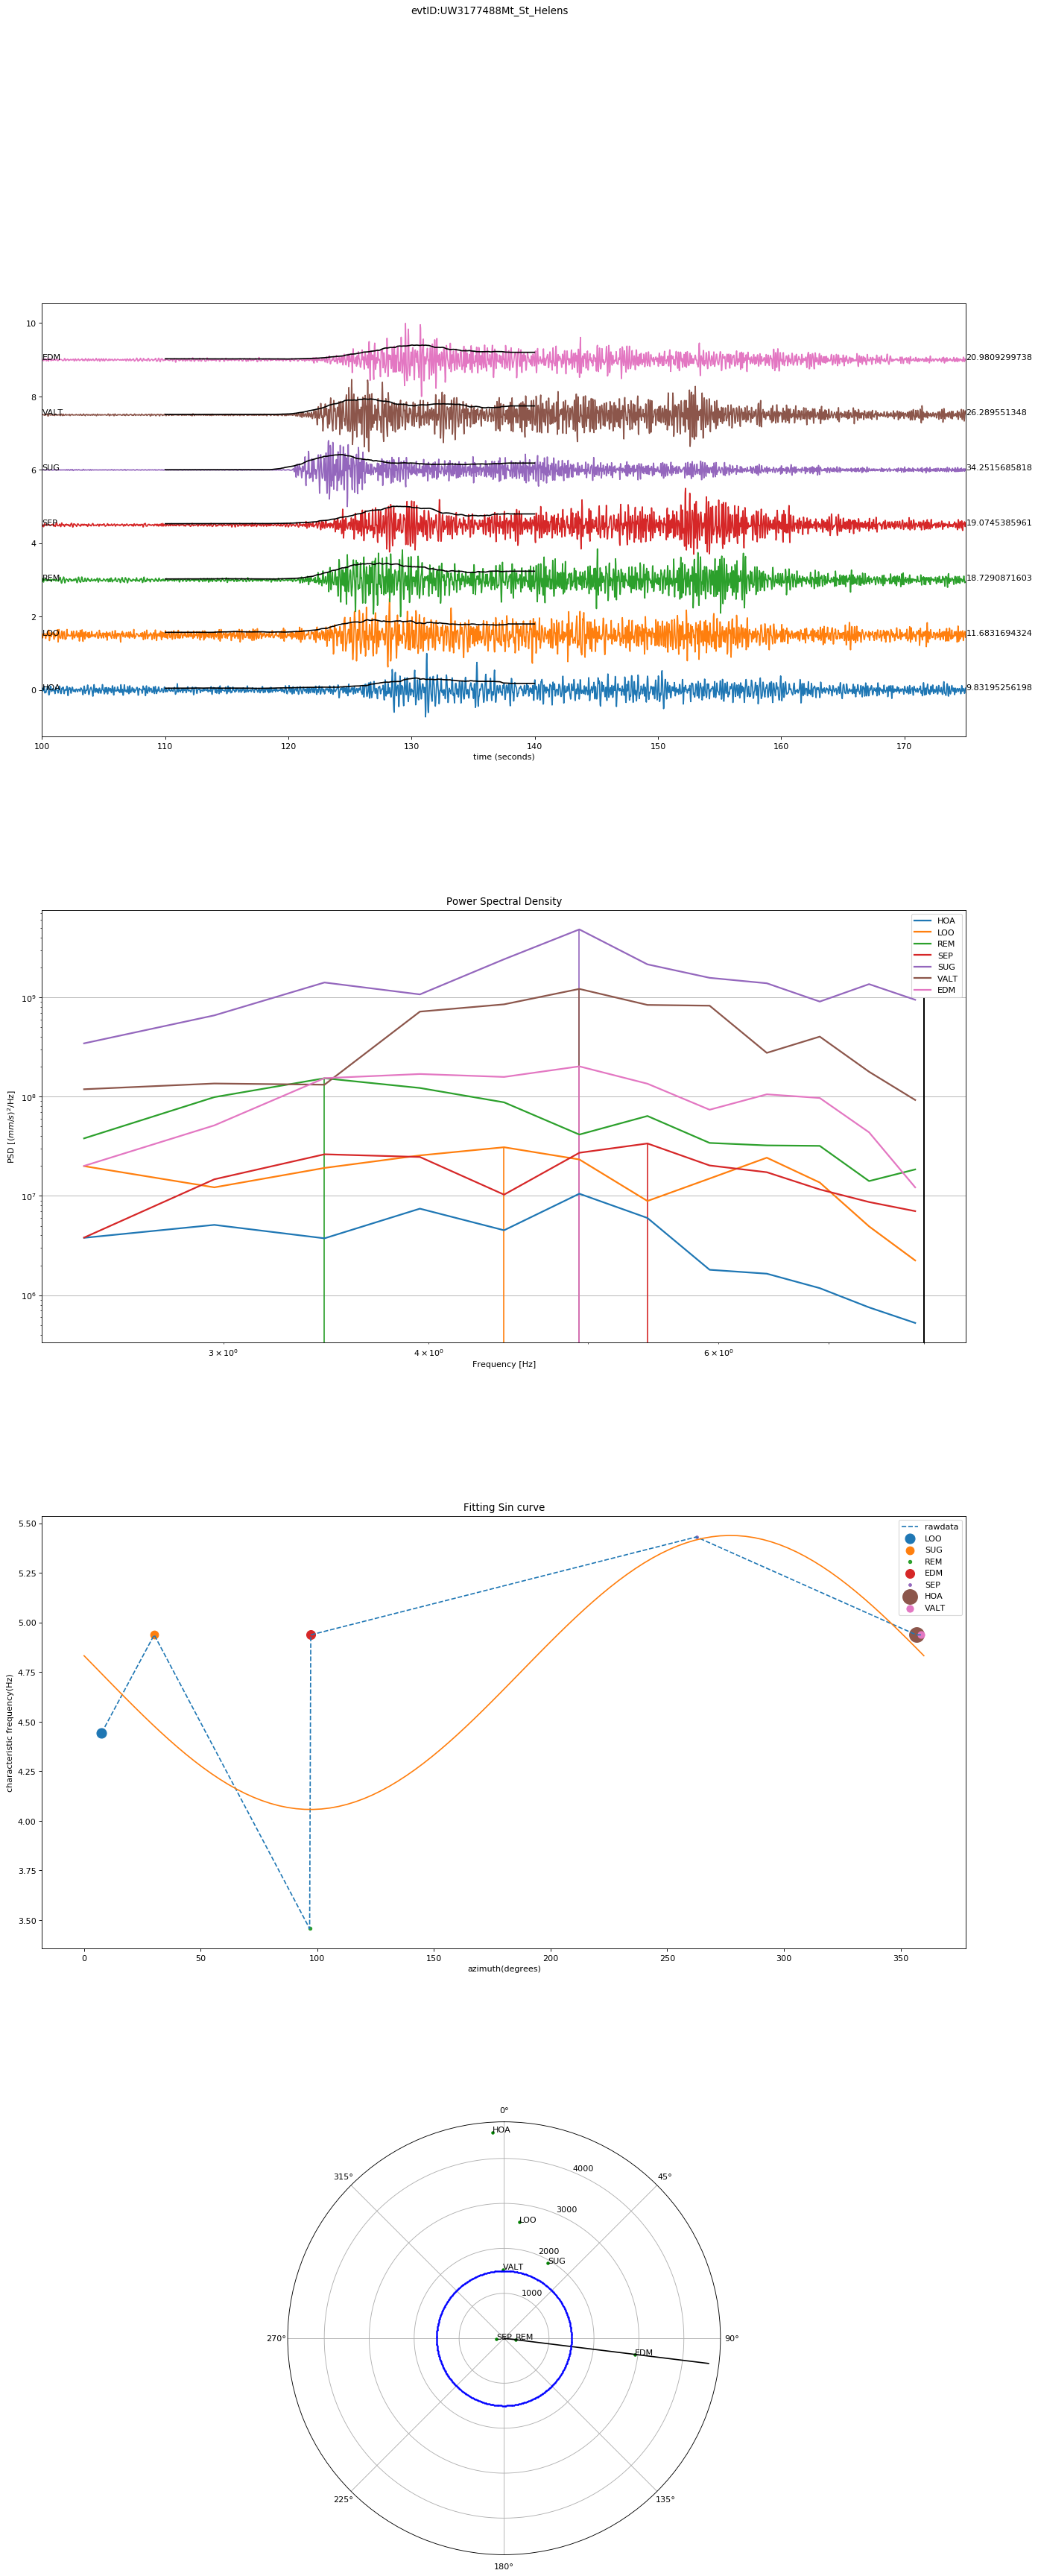

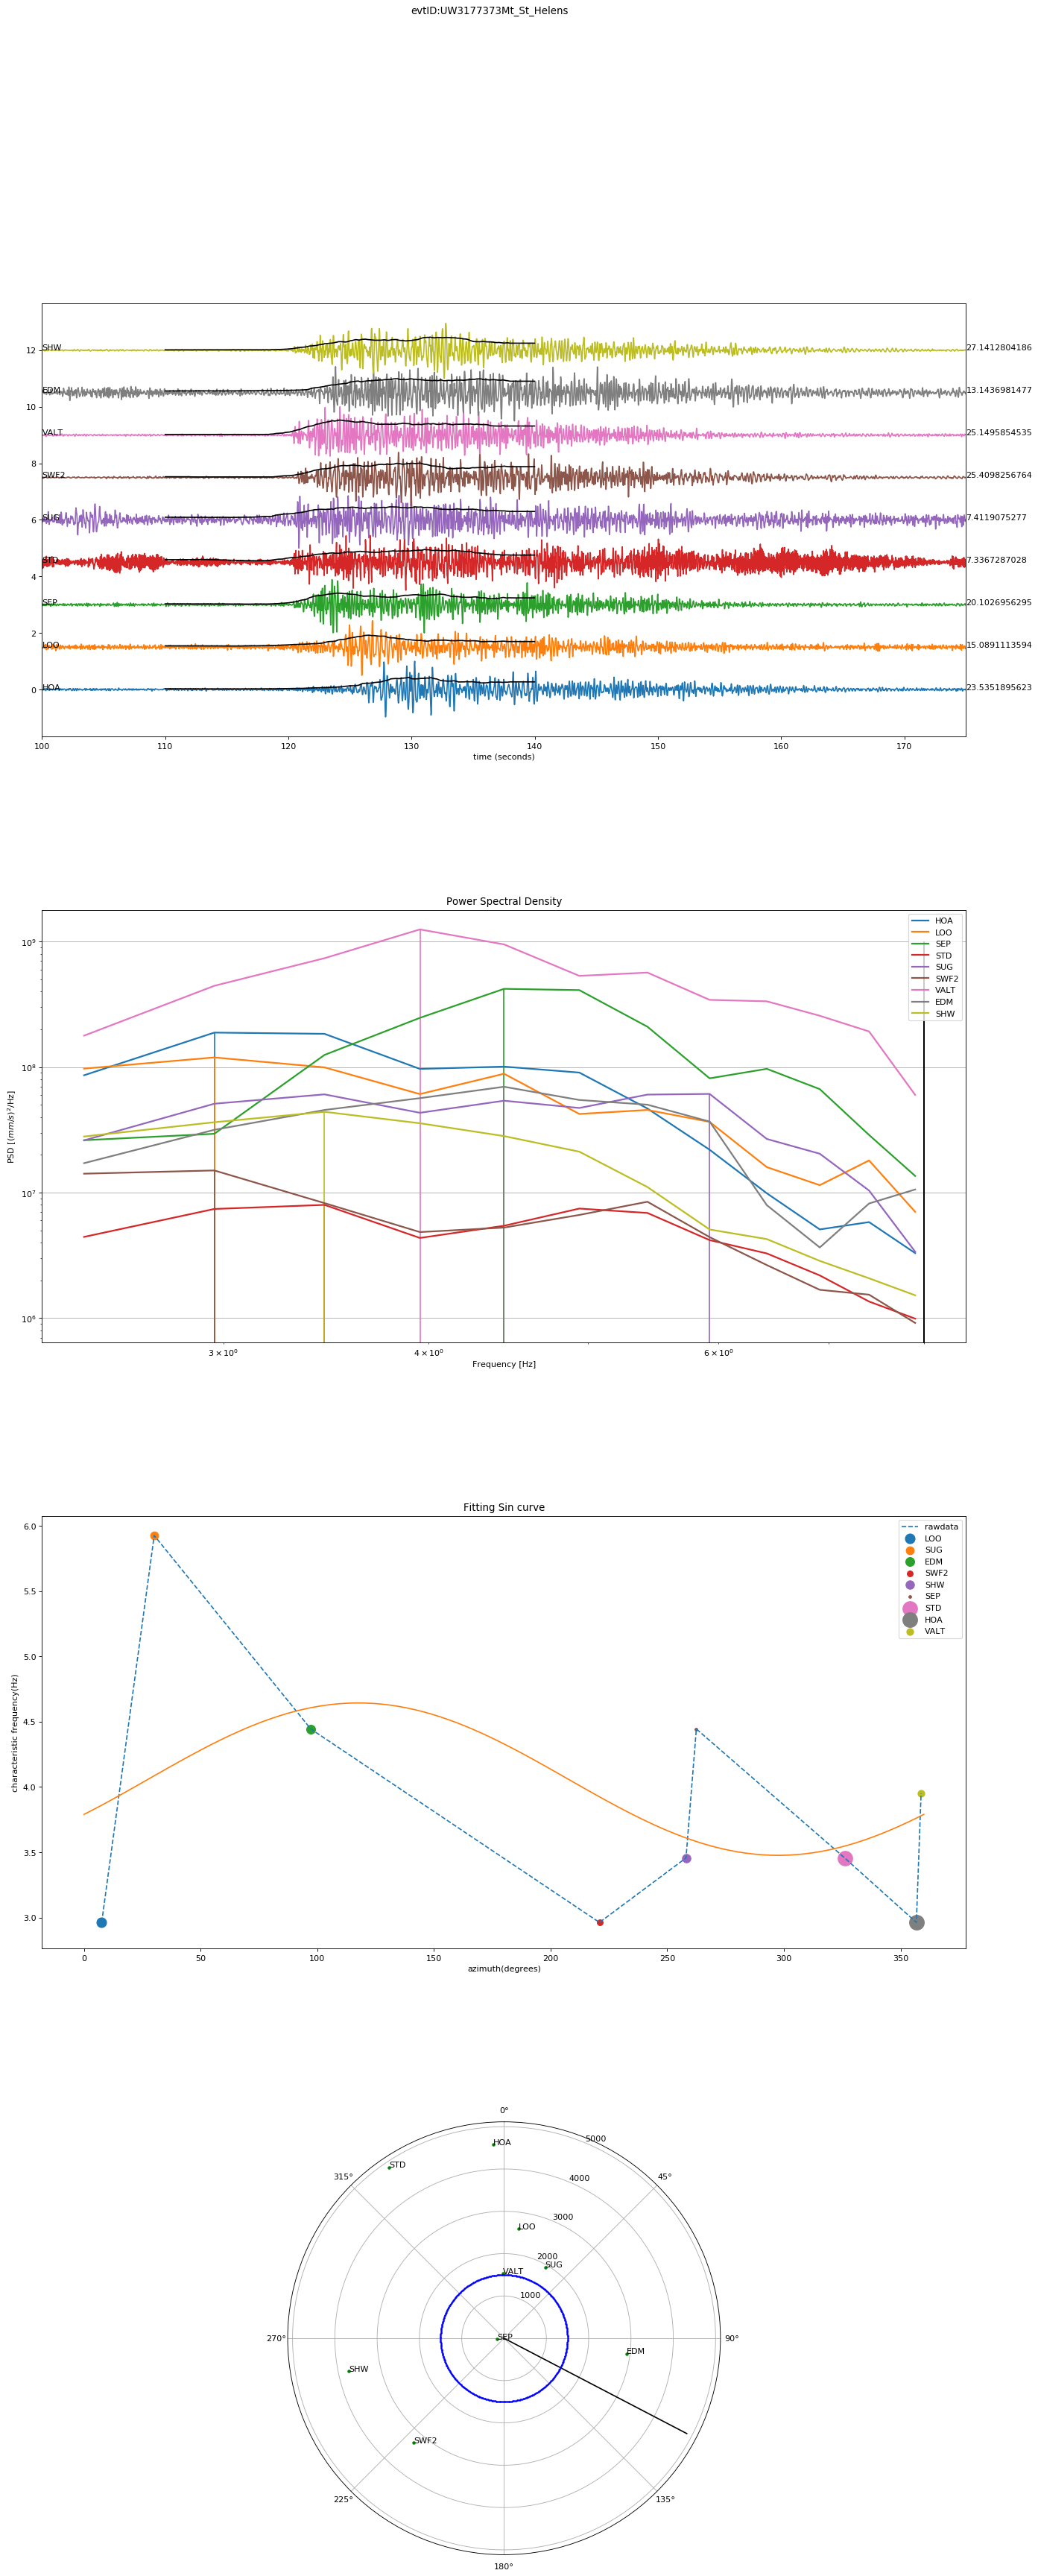

In [35]:
plt.rcParams.update({'font.size': 10})
for n in range(249,260):
    event_ID = str(evt_id[n])
    t = UTCDateTime(start_time[n])
    if net != 'CN' and evt_id[n]!=evt_id[n-1]:
        if t_beginning<=t<=t_end:
            reference = str(net[n]+'.'+sta[n])
            try:
                associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
            except: 
                associated_volcano = 'unknown'

            if associated_volcano == 'unknown':
                pass
            else:
                stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
                networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
                latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
                longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
                elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()
                volc_lat = volc_lat_lon[associated_volcano][0]
                volc_lon = volc_lat_lon[associated_volcano][1]
                  
                bulk = [] 
                for m in range(0, len(networks)):
                    bulk.append([networks[m], stations[m], '*', '*', t-t_before, t+t_after])
                st = client.get_waveforms_bulk(bulk)
                for tr in st:
                    if tr.stats.channel[0:2] != 'BH' and tr.stats.channel[0:2] != 'EH' and tr.stats.channel[0:2] != 'HH':
                            st.remove(tr)
                            continue
                    if len(tr.data)/tr.stats.sampling_rate < 239.9:
                        st.remove(tr)
            #resampling the data to 40Hz for each trace
                st = resample(st,fs) 
            #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-15Hz
                SNR, stas, data_env_dict = [], [], {}
                
                fig = plt.figure(figsize = (20,50), dpi=80)
                plt.subplots_adjust(hspace = .4)
                fig.suptitle('evtID:UW'+ event_ID+associated_volcano)

                ax1 = plt.subplot(4,1,1)
                iplot = 0
                for g,x in enumerate(st):
                    t = x.times()
                    x.detrend(type = 'demean')
                    x.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
                    network = x.stats.network
                    station = x.stats.station
                    cha = x.stats.channel
                    starttime = x.stats.starttime
                    smooth_length = 2*fs

                    signal_window = x.copy()
                    noise_window = x.copy()
                    #TODO: fix signal window to be around the max amplitude
                    signal_window.trim(starttime+t_before-1, starttime+t_before-1+window)
                    noise_window.trim(starttime-window+t_before-10, starttime+t_before-10)

                    SNR.append(20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                                   / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

                    if cha[-1] == 'Z' and SNR[g]>thr:
                        #enveloping the data
                        data_envelope = obspy.signal.filter.envelope(x.data[110*fs:140*fs])
                        data_envelope /= np.max(data_envelope)
                        data_envelope += iplot*1.5
                        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
                        data_env_dict[network+'.'+station]= data_envelope

                        ax1.plot(t[100*fs:175*fs],x.data[100*fs:175*fs]/np.max(np.abs(x.data))+iplot*1.5)
                        ax1.plot(t[110*fs:140*fs], data_envelope, color = 'k')
                        ax1.set_xlabel('time (seconds)')
                        ax1.set_xlim([100,175])
                        plt.text(t[175*fs], iplot*1.5, str(SNR[g]))
                        plt.text(t[100*fs], iplot*1.5, x.stats.station)
                        iplot = iplot+1

                        stas.append(x.stats.station)
                    else:
                        st.remove(x)
        
                if len(st)>=4:
                    dist, pick_times, lats, lons, elevs, r, theta, Sta = ([] for i in range(8))
                    for s in range(0, len(stas)):
                        dist.append(df[df['Station'] == stas[s]]['Distance_from_volc'].values[0]) 

                    for key in data_env_dict:
                        p = pick_time(data_env_dict[reference], data_env_dict[key])
                        pick_times.append(p)
                   
                    for i, ii in enumerate(stas):
                        a = stations.index(ii)
                        lats.append(latitudes[a])
                        lons.append(longitudes[a])
                        elevs.append(elevations[a])
                        #calculating azimuth for each station with respect to the middle of the volcano
                        lat2 = lats[i]
                        lon2 = lons[i]
                        lat1 = volc_lat
                        lon1 = volc_lon
                        u,b,c = (gps2dist_azimuth(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805))
                        r.append(u)
                        theta.append(b)
                        Sta.append(stas[i])
                            
                    #select station and component
                    #figure this out 
                    ax2 = plt.subplot(4,1,2)
                    ax2.set_title('Power Spectral Density')
                    spectra_method = "welch"
                    char_freq_method = "mean"
                    # read and preprocess data
                    # which frequencies do I want the low_cut and high_cut to be?
                    st.filter("bandpass",freqmin=low_cut,freqmax=high_cut)
                    st.taper(max_percentage=0.01,max_length=20)
                    st.trim(starttime=min(pick_times),endtime=min(pick_times)+20) 
                    
                    # make plot of spectra
                    colors = list(plt.cm.tab10(np.arange(10))) + ["crimson", "indigo", "powderblue", "lime"]
                    char_freq, spectra_list, weight= [],[],[]
                    for i in range(len(Sta)):
                        try:
                            data = st.select(station=Sta[i],component="Z")[0].data*100
                            a = 'stream is not empty'
                        except:
                            pass
                        if a == 'stream is not empty':
                            f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
                            #just get the indices of frequencies within the filter band
                            above_low_cut = [f>low_cut]
                            below_high_cut = [f<high_cut]
                            in_band = np.logical_and(above_low_cut,below_high_cut)[0]
                            f = f[in_band]
                            psd = psd[in_band]
                            ratio = (np.mean(psd)/np.max(psd))
                            print(ratio, Sta[i])
                            weight.append(int(1/(ratio**2)*20))
                            
                            ax2.plot(f,psd,label=Sta[i],linewidth=2)
                            ax2.set_xscale('log')
                            ax2.set_yscale('log')
                            ax2.set_xlabel('Frequency [Hz]')
                            ax2.set_ylabel('PSD [$(mm/s)^2$/Hz]')
                            spectra_list.append(psd)
                            ax2.legend()
                            ax2.grid(True)

                        # calculate characteristic frequency and report
#                             if char_freq_method == "max":
                            char_freq_max = f[np.argmax(psd)]
#                             elif char_freq_method == "mean":
                            char_freq_mean= np.sum(psd*f)/np.sum(psd)
#                             elif char_freq_method == "median":
#                                 psd_cumsum = np.cumsum(psd)
#                                 psd_sum = np.sum(psd)
#                                 char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
                            char_freq.append(char_freq_max)
                            ymax=max(psd)
                            plt.vlines(char_freq_max, ymin=0, ymax = ymax, color = colors[i])
                            plt.vlines(8, ymin = 0, ymax = 10**9, color = 'k')

                    if a == 'stream is not empty':
                        #manipulating the data
                        data = {'azimuth':theta, 'freq':char_freq, 'station':Sta, 'distance':dist, 'weight':weight}
                        DF = pd.DataFrame(data, index = None)
                        DF2 = DF.sort_values('azimuth')
                        y_data =  DF2["freq"].values.tolist()
                        #colors2 = DF2["color"].values.tolist()
                        Sta2 = DF2["station"].values.tolist()
                        dist2 = DF2["distance"].values.tolist()
                        weight2 = DF2["weight"].values.tolist()
                        x_data =  np.asarray(DF2["azimuth"].values.tolist())
                        x_points = np.linspace(0,360, 100)
                        ax3 = plt.subplot(4,1,3)
                        ax3.set_title('Fitting Sin curve')
                        ax3.set_ylabel('characteristic frequency(Hz)')
                        ax3.set_xlabel('azimuth(degrees)')
                        for i in range (0,len(Sta2)):
                            ax3.scatter(x_data[i], y_data[i], s = (dist2[i]**2*10), label=Sta2[i])
                        ax3.plot(x_data,y_data, '--', label='rawdata')
                        ax3.legend(loc='best')
                        #weighting the data
                        print(x_data, 'original')
                        tempx, tempy = [],[]
                        for i,ii in enumerate(x_data):
                            tempx.append([])
                            tempx[i].append([ii for l in range(0,weight[i])])
                            tempy.append([])
                            tempy[i].append([y_data[i] for l in range(0,weight[i])])
                            
                        weighted_x = sum(sum(tempx, []),[])
                        weighted_y = sum(sum(tempy, []),[])
#                         print(len(weighted_x), len(weighted_y))
#                         print(weighted_x, weighted_y)
                    
                        
                        
                        #optimizing parameters to fit weighted data to test_function
                        params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(weighted_x), weighted_y, p0=None)
                        d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
                        ax3.plot(x_points, d, label='Fitted function')
                       

                        
                        
                        len_r = int(max(r))
                        line_length = np.linspace(0,len_r,len_r+1)
                        rads = np.arange(0, (2 *pi), 0.01)
                        direction=[]
                        direction = [(params[1]) for i in range(len_r+1)]
                        
                        
                        ax4= plt.subplot(4,1,4, polar=True)
                        ax4.set_theta_offset(pi/2)
                        ax4.set_theta_direction(-1)
                        for i in range(0,len(r)):
                            ax4.plot(np.deg2rad(theta[i]),r[i], 'g.')
                            ax4.text(np.deg2rad(theta[i]),r[i],stas[i]) 
                        ax4.plot(direction,line_length, 'k-')  #plot the estimated direction of the event
                        for rad in rads:
                            ax4.plot(rad,az_thr, 'b.', markersize = 2)

#                         #calculating velocity from the frequency shift
                        fmax = max(d)
                        fmin = min(d)
                        v = v_s*((fmax-fmin)/(fmax+fmin))
                        print(v,'m/s')

                        plt.savefig('evtID:UW'+ event_ID+associated_volcano+'weighted.png')


In [33]:
print(weight)

[26, 22, 28, 17, 15, 24, 25, 21, 23]


Finding a way to weight the data by spikeyness of PSD curve

In [ ]:
#brainstorm: 
    #ratio of highest amplitude of PSD to mean psd value
        #if close to one than weighted small
        #if close to zero than weighted large
        #would need to normalize each curve on its own
    #use log, root, or cube root to make sure it is not weighted by a crazy amount

In [446]:
print(np.max(psd))
print(10**8)
print(np.mean(psd))
print(Sta2)
print(np.mean(psd)/np.max(psd))

14749346.5709
100000000
7615312.17289
['LOO', 'SUG', 'EDM', 'SEP', 'STD', 'HOA', 'VALT']
0.516315223613


Test Data Set

In [ ]:
y=[0.7071072502792263, 0.2588201130902432, -0.2588175499191776, -0.707105373906644, -0.9659251967199323, -0.9659265703179515, -0.7071091266468291, -0.2588226762594864, 0.25881498674628944, 0.7071034975290827, 0.9659245099107202, 0.9659272571067586]
other_y = [1.0, 0.8660256249168368, 0.5000007660251953, 1.3267948966775328e-06, -0.49999846794843594, -0.8660242981199074, -0.9999999999964793, -0.8660269517076681, -0.5000030640984338, -3.9803846904673455e-06, 0.49999616986815654, 0.8660229713168799]
x = [0,30,60,90,120,150,180,210,240,270,300,330]
x_points = np.linspace(0,360, 100)

plt.plot(x,y)
params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x), other_y, p0=None)
d = test_func(np.deg2rad(x), params[0], params[1], params[2])
plt.plot(x, d, label='Fitted function')



# Mount St Helens Event

In [ ]:
#Read in Stream Data
bulk = []
associated_volcano = 'Mt_St_Helens'
t = UTCDateTime(2022,8,5,9,12)
event_ID = '61860332'

networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()
volc_lat = 46.200472222222224 #volc_lat_lon[associated_volcano][0]
volc_lon =-122.18883611111112 #volc_lat_lon[associated_volcano][1]

for m in range(0, len(networks)):
    bulk.append([networks[m], stations[m], '*', '*', t-t_before, t+t_after])
st = client2.get_waveforms_bulk(bulk)
for tr in st:
    if tr.stats.channel[0:2] != 'BH' and tr.stats.channel[0:2] != 'EH' and tr.stats.channel[0:2] != 'HH':
            st.remove(tr)
            continue
    if len(tr.data)/tr.stats.sampling_rate < 239.9:
        st.remove(tr)
st = resample(st,fs) 

for i in st:
    if i.stats.station == 'ASR':
        st.remove(i)

In [ ]:
thr = 3
SNR = []
stas = []
data_env_dict = {}

fig = plt.figure(figsize = (20,50), dpi=80)
plt.subplots_adjust(hspace = .4)
fig.suptitle('evtID:UW'+ event_ID+associated_volcano)

ax1 = plt.subplot(4,1,1)
iplot = 0
for g,x in enumerate(st):
    t = x.times()
    x.detrend(type = 'demean')
    x.filter('bandpass',freqmin=2.0,freqmax=19.0,corners=2,zerophase=True)

    network = x.stats.network
    station = x.stats.station
    cha = x.stats.channel
    starttime = x.stats.starttime
    smooth_length = 2*fs

    signal_window = x.copy()
    noise_window = x.copy()
    signal_window.trim(starttime+t_before-1, starttime+t_before-1+window)
    noise_window.trim(starttime-window+t_before-10, starttime+t_before-10)

    SNR.append(20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                   / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

    if cha[-1] == 'Z' and SNR[g]>thr:
        #enveloping the data
        data_envelope = obspy.signal.filter.envelope(x.data[145*fs:165*fs])
        data_envelope /= np.max(data_envelope)
        data_envelope += iplot*1.5
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
        data_env_dict[network+'.'+station]= data_envelope

        ax1.plot(t[145*fs:175*fs],x.data[145*fs:175*fs]/np.max(np.abs(x.data))+iplot*1.5)
        ax1.plot(t[145*fs:165*fs], data_envelope, color = 'k')
        ax1.set_xlabel('time (seconds)')
        #ax1.vlines(120, ymin = 0, ymax = 1.5*iplot, color = 'k')
        ax1.set_xlim([145,175])
        plt.text(t[175*fs], iplot*1.5, str(SNR[g]))
        plt.text(t[145*fs], iplot*1.5, x.stats.station)
        iplot = iplot+1

        stas.append(x.stats.station)
    else:
        st.remove(x)
print(stas)
                
dist = []
for s in range(0, len(stas)):
    dist.append(df[df['Station'] == stas[s]]['Distance_from_volc'].values[0])
if dist[s] < 1:
    print(stas[s],dist[s])




reference = 'CC.SEP'
if len(st)>=4:
    pick_times = []
    ref_env = data_env_dict[reference]
for key in data_env_dict:
    p = pick_time(ref_env, data_env_dict[key])
    pick_times.append(p)

lats = []
lons = []
elevs = []
for i in stas:
    a = stations.index(i)
    lats.append(latitudes[a])
    lons.append(longitudes[a])
    elevs.append(elevations[a])

#calculating azimuth for each station with respect to the middle of the volcano
azimuth = []
distance = []
for i in range(0, len(stas)):
    lat2 = lats[i]
    lon2 = lons[i]
    lat1 = volc_lat
    lon1 = volc_lon
    u,b,c = (gps2dist_azimuth(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805))
    azimuth.append(b)
    distance.append(u)
#select station and component
ax2 = plt.subplot(4,1,2)
ax2.set_title('Power Spectral Density')
Sta = stas
spectra_method = "welch"
char_freq_method = "mean"

# read and preprocess data
# which frequencies do I want the low_cut and high_cut to be?
st.filter("bandpass",freqmin=low_cut,freqmax=high_cut)
st.taper(max_percentage=0.01,max_length=20)
st.trim(starttime=min(pick_times),endtime=min(pick_times)+20) 

# make plot of spectra
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
char_freq = []
spectra_list = []

print(Sta)
for i in range(len(Sta)):
    try:
        data = st.select(station=Sta[i],component="Z")[0].data*100
        a = 'stream is not empty'
    except:
        print('stream is empty')
        pass

    if a == 'stream is not empty':
        f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)

# just get the indices of frequencies within the filter band
        above_low_cut = [f>low_cut]
        below_high_cut = [f<high_cut]
        in_band = np.logical_and(above_low_cut,below_high_cut)[0]
        f = f[in_band]
        psd = psd[in_band]

        ax2.plot(f,psd,label=Sta[i],linewidth=2)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('Frequency [Hz]')
        ax2.set_ylabel('PSD [$(mm/s)^2$/Hz]')
        spectra_list.append(psd)
        ax2.legend()

# calculate characteristic frequency and report
#                             if char_freq_method == "max":
#                                 char_freq_max = f[np.argmax(psd)]
#                             elif char_freq_method == "mean":
        char_freq_mean= np.sum(psd*f)/np.sum(psd)
    #                             elif char_freq_method == "median":
    #                                 psd_cumsum = np.cumsum(psd)
    #                                 psd_sum = np.sum(psd)
    #                                 char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]

        char_freq.append(char_freq_mean)

        ymax=np.max(psd)*10

    #             plt.vlines(char_freq_max, ymin=0, ymax = ymax, color = 'k')
        
        ax2.vlines(char_freq_mean, ymin=0, ymax = ymax, color = colors[i])

    #             plt.vlines(char_freq_median, ymin=0, ymax = ymax, color = 'deeppink')
        ax2.grid(True)
if a == 'stream is not empty':
#plotting azimuth versus characteristic frequency for each station
    ydata = char_freq

    #optimizing parameters to fit data to test_function
    params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(azimuth), ydata, p0=None)

    #manipulating the data
    data = {'azimuth':azimuth, 'freq':ydata, 'station':stas}
    DF = pd.DataFrame(data, index = None)
    DF2 = DF.sort_values('azimuth')
    y_data =  DF2["freq"].values.tolist()
    x_data =  DF2["azimuth"].values.tolist()
    x_data = np.asarray(x_data)
    x_points = np.linspace(0,360, 100)
    #plotting the raw data and the fitted curve

    d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])

    ax3 = plt.subplot(4,1,3)
    ax3.set_title('Fitting Sin curve')
    ax3.set_ylabel('characteristic frequency(Hz)')
    ax3.set_xlabel('azimuth(degrees)')
    for i in range(0,len(Sta)):
        ax3.scatter(x_data[i], y_data[i], s = (dist[i]**2*10), label=Sta[i])
    ax3.plot(x_points, d, label='Fitted function')
    ax3.plot(x_data,y_data, '--', label='rawdata')
    ax3.legend(loc='best')

    ax4= plt.subplot(4,1,4, polar=True)
    ax4.set_theta_offset(pi/2)
    ax4.set_theta_direction(-1)
    r = []
    theta = []
    for y in range(0, len(azimuth)):
        r.append(distance[y])
        theta.append(azimuth[y])
    for t in theta:
        if t > 360:
            i = theta.index(t)
            theta = theta[:i]+[t-360]+theta[i+1:]       
    for i in range(0,len(r)):
        ax4.plot(np.deg2rad(theta[i]), r[i], 'g.')
        ax4.text(np.deg2rad(theta[i]),r[i],stas[i]) 
    
    len_r = int(max(r))
    line_length = np.linspace(0,len_r,len_r+1)
    direction=[]
    direction = [np.rad2deg(params[1]) for i in range(len_r+1)] 
    ax4.plot(direction,line_length, 'k-')  #plot the estimated direction of the event

    #calculating velocity from the frequency shift
    fmax = max(d)
    fmin = min(d)
    v = v_s*((fmax-fmin)/(fmax+fmin))
    print(v,'m/s')

    #plt.savefig('evtID:UW'+ event_ID+associated_volcano+'.png')


In [ ]:
print(theta)
print(Sta)
for t in theta:
    print(t)
    if t > 360:
        i = theta.index(t)
        print(theta[:i])
#         theta = theta[:i]+[t-360]+theta[i+1:]
#     print(theta)

In [ ]:
thr = 0
SNR2 = []
stas2= []
data_env_dict2 = {}

fig = plt.figure(figsize = (20,50), dpi=80)
plt.subplots_adjust(hspace = .4)
fig.suptitle('evtID:UW'+ event_ID+associated_volcano)

ax2 = plt.subplot(4,1,1)
iplot = 0
for g,x in enumerate(st):
    t = x.times()
    x.detrend(type = 'demean')
    x.filter('lowpass',freq = 2, corners=2,zerophase=True)


    network = x.stats.network
    station = x.stats.station
    cha = x.stats.channel
    starttime = x.stats.starttime
    smooth_length = 2*fs

    signal_window = x.copy()
    noise_window = x.copy()
    signal_window.trim(starttime+t_before-1, starttime+t_before-1+window)
    noise_window.trim(starttime-window+t_before-10, starttime+t_before-10)

    SNR2.append(20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                   / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

    if cha[-1] == 'Z' and SNR2[g]>thr:
        #enveloping the data
        data_envelope = obspy.signal.filter.envelope(x.data[145*fs:165*fs])
        data_envelope /= np.max(data_envelope)
        data_envelope += iplot*1.5
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
        data_env_dict2[network+'.'+station]= data_envelope

        ax2.plot(t[145*fs:175*fs],x.data[145*fs:175*fs]/np.max(np.abs(x.data))+iplot*1.5)
        ax2.plot(t[145*fs:165*fs], data_envelope, color = 'k')
        ax2.set_ylabel('Velocity (m/s)')
        ax2.set_xlabel('time (seconds)')
        #ax1.vlines(120, ymin = 0, ymax = 1.5*iplot, color = 'k')
        ax2.set_xlim([145,175])
        plt.text(t[175*fs], iplot*1.5, str(SNR[g]))
        plt.text(t[145*fs], iplot*1.5, x.stats.station)
        iplot = iplot+1

        stas2.append(x.stats.station)